# Loading all the libraries and modules

In [1]:
!pip install autocorrect
!pip install transformers==3.0.0

In [2]:
from utils.preprocess import Preprocess
from utils import Utils
from google.colab import drive

drive.mount('/content/gdrive')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/raju/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/raju/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raju/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raju/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/raju/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to /home/raju/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:
import time
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Conv1D, LSTM, Bidirectional, Dropout, BatchNormalization, LayerNormalization, Concatenate 
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.layers import LeakyReLU, PReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential

from transformers import TFBertModel, BertConfig, BertTokenizer, TFAutoModel
from transformers import TFDistilBertModel, DistilBertConfig, DistilBertModel, DistilBertTokenizer
from transformers import TFRobertaModel, RobertaConfig, RobertaModel, RobertaTokenizer
from transformers import TFAutoModel, AutoModel, AutoConfig, AutoTokenizer
from transformers import TFAutoModelForSequenceClassification, AutoModelForSequenceClassification, BertForSequenceClassification, TFDistilBertForSequenceClassification
from transformers import AdamW


import gc
import warnings
warnings.filterwarnings('ignore')

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.4.1


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


# Prepare Dataset

In [3]:
%%time
utils = Utils()
pre = Preprocess(mode="clean")

CPU times: user 3.9 s, sys: 191 ms, total: 4.09 s
Wall time: 4.4 s


In [4]:
train_data = utils.read_data("/content/gdrive/My Drive/WASSA-2021-Shared-Task/dataset/train-empathy-distress-prediction-task-normalized.csv")
print(train_data.shape)
dev_data = utils.read_data("/content/gdrive/My Drive/WASSA-2021-Shared-Task/dataset/dev-empathy-distress-prediction-task-normalized.csv")
print(dev_data.shape)

(1860, 28)
(270, 23)


In [5]:
wordweight= utils.get_word_weights(train_data["essay"],train_data["empathy_bin"])
print(len(wordweight))

10156


In [8]:
x=utils.get_essay_score(train_data["essay"],wordweight)
x

array([[ 5.80889984],
       [10.44796678],
       [ 9.09725443],
       ...,
       [-3.15546789],
       [-4.44355047],
       [-1.70861401]])

# Run Multi-task learning model

In [34]:
%%time
myModel = MTLM(base_model_type="RoBERTa",
               cpkt="new-mtlm-bin-emotion-demographics-race-32-score-16-RoBERTa-tanh-avg-128",
               activation="tanh",
               kr_rate=0.001,
               score_loss="huber")

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


CPU times: user 1.06 s, sys: 237 ms, total: 1.3 s
Wall time: 2.34 s


# For normal DL models

In [ ]:
%%time
prepared_train_essay, myTokenizer = myModel.prepare_input(utils,
                                                          train_essay, 
                                                          maxlen=200, 
                                                          padding_type='post', 
                                                          truncating_type='post', 
                                                          mode="train")
print(prepared_train_essay.shape)
vocab = list(myTokenizer.word_index.keys())
print(len(vocab))

(1674, 200)
8743
CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 186 ms


In [ ]:
%%time
prepared_dev_essay = myModel.prepare_input(utils,
                                           dev_essay, 
                                           maxlen=200, 
                                           padding_type='post', 
                                           truncating_type='post', 
                                           mode="test")
print(prepared_dev_essay.shape)

In [ ]:
%%time
embedding_matrix = utils.get_embedding_matrix("/content/gdrive/My Drive/word-embeddings/glove.word2vec.6B.300d.bin", 
                                              vocab, 
                                              top=100000)
print(embedding_matrix.shape)

In [ ]:
%%time
myModel.build(embedding_matrix, 
              input_length=200)

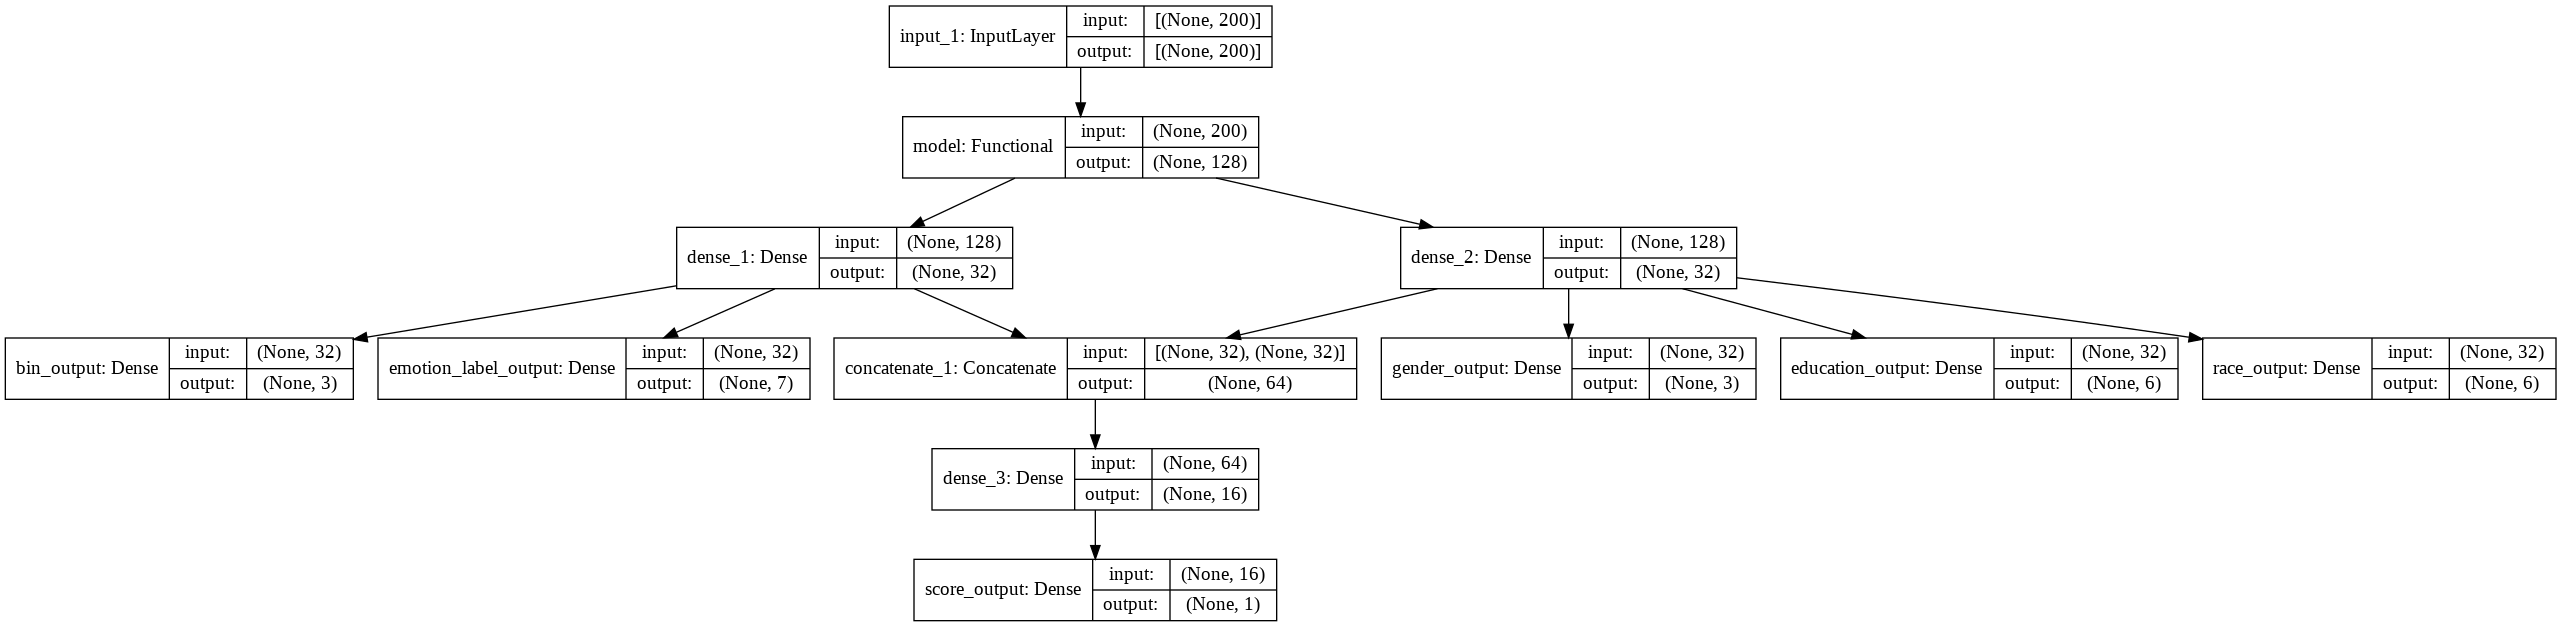

In [ ]:
model_arch = myModel.plot_model_arch()
model_arch

In [ ]:
%%time
histroy = myModel.train(prepared_train_essay,
                        train_outputs, 
                        prepared_val_essay, 
                        val_outputs,
                        epochs=200,
                        batch_size=32)

In [ ]:
%%time
y_pred = myModel.prediction(prepared_val_essay, 
                            model_path="mtlm-emotions-demographic-groups-RoBERTa-epoch-09-val-loss-2.358688.h5")
print(y_pred.shape)

In [ ]:
%%time
corr = myModel.correlation(val_outputs[-1], y_pred)
print("Pearson's Correlation", corr[0])
print("P-value", corr[1])

In [ ]:
#MODEL = "cardiffnlp/bertweet-base-emotion"
MODEL = "nateraw/bert-base-uncased-emotion"
#MODEL = "cardiffnlp/twitter-roberta-base-emotion"

config = AutoConfig.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


Some weights of the model checkpoint at nateraw/bert-base-uncased-emotion were not used when initializing BertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# For BERT based models

In [44]:
%%time
prepared_train = myModel.prepare_input(utils,
                                       train_data,
                                       maxlen=200)
print(len(prepared_train))
print(prepared_train[0].shape)

2
(1860, 200)
CPU times: user 1.38 s, sys: 225 µs, total: 1.38 s
Wall time: 1.38 s


In [45]:
%%time
prepared_dev = myModel.prepare_input(utils,
                                     dev_data,
                                     maxlen=200)
print(len(prepared_dev))
print(prepared_dev[0].shape)

2
(270, 200)
CPU times: user 195 ms, sys: 0 ns, total: 195 ms
Wall time: 196 ms


In [37]:
%%time
train_outputs = myModel.prepare_output(utils, train_data, task="empathy", mode="train")
print(len(train_outputs))
print(train_outputs[0].shape)

dev_outputs = myModel.prepare_output(utils, dev_data, task="empathy", mode="val")
print(len(dev_outputs))
print(dev_outputs[0].shape)

7
(1860, 1)
7
(270, 1)
CPU times: user 6.98 ms, sys: 996 µs, total: 7.98 ms
Wall time: 8.07 ms


In [38]:
%%time
myModel.build(np.zeros((1,1)), 
              input_length=200)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          124744064   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           4128        model[0][0]                

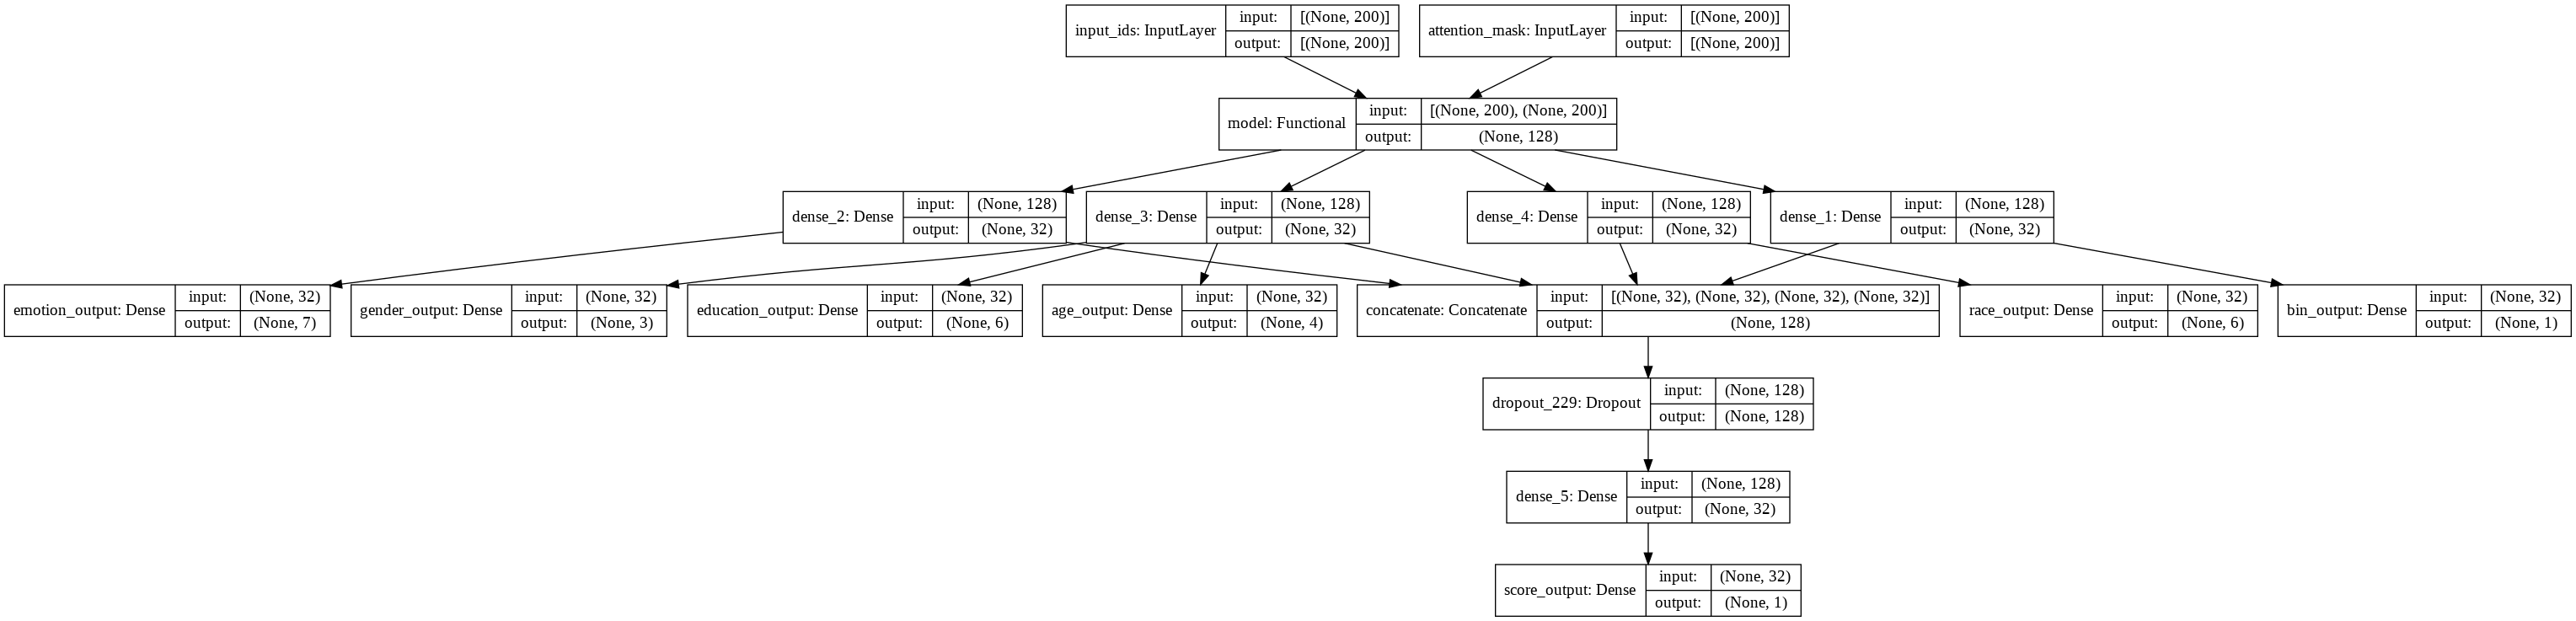

In [40]:
model_arch = myModel.plot_model_arch()
model_arch

In [41]:
%%time
histroy = myModel.train(prepared_train,
                        train_outputs, 
                        prepared_dev, 
                        dev_outputs,
                        epochs=200,
                        batch_size=32)

Epoch 1/200
59/59 [==============================] - 48s 616ms/step - loss: 9.3704 - bin_output_loss: 0.7165 - emotion_output_loss: 1.8901 - gender_output_loss: 0.8046 - education_output_loss: 1.5474 - age_output_loss: 1.0410 - race_output_loss: 1.0345 - score_output_loss: 1.8635 - score_output_mean_squared_error: 4.2882 - val_loss: 8.7108 - val_bin_output_loss: 0.6886 - val_emotion_output_loss: 1.6130 - val_gender_output_loss: 0.7897 - val_education_output_loss: 1.6128 - val_age_output_loss: 1.0350 - val_race_output_loss: 0.9854 - val_score_output_loss: 1.5281 - val_score_output_mean_squared_error: 3.2273
Epoch 2/200
59/59 [==============================] - 32s 546ms/step - loss: 8.2721 - bin_output_loss: 0.6662 - emotion_output_loss: 1.6940 - gender_output_loss: 0.7138 - education_output_loss: 1.4424 - age_output_loss: 0.9667 - race_output_loss: 0.8815 - score_output_loss: 1.4535 - score_output_mean_squared_error: 3.0801 - val_loss: 8.3816 - val_bin_output_loss: 0.6466 - val_emotion_

# Correlation on Validation Data

In [42]:
%%time
y_pred = myModel.prediction(prepared_dev, 
                            model_path="new-mtlm-bin-emotion-demographics-race-32-score-16-RoBERTa-tanh-avg-128-huber-2.0-epoch-20-val-loss-1.239757.h5")
print(y_pred.shape)

(270, 1)
CPU times: user 3.32 s, sys: 440 ms, total: 3.76 s
Wall time: 9.51 s


In [43]:
%%time
corr = myModel.correlation(dev_outputs[-1], y_pred)
print("Pearson's Correlation", round(corr[0], 5))
print("P-value: ", round(corr[1], 5))

Pearson's Correlation 0.48539
P-value:  0.0
CPU times: user 953 µs, sys: 0 ns, total: 953 µs
Wall time: 8.86 ms


# Correlation on Validation Data

In [46]:
%%time
y_pred = myModel.prediction(prepared_train, 
                            model_path="new-mtlm-bin-emotion-demographics-race-32-score-16-RoBERTa-tanh-avg-128-huber-2.0-epoch-20-val-loss-1.239757.h5")
print(y_pred.shape)

(1860, 1)
CPU times: user 4.1 s, sys: 1.48 s, total: 5.58 s
Wall time: 26.3 s


In [47]:
%%time
corr = myModel.correlation(train_outputs[-1], y_pred)
print("Pearson's Correlation", round(corr[0], 5))
print("P-value: ", round(corr[1], 5))

Pearson's Correlation 0.59011
P-value:  0.0
CPU times: user 980 µs, sys: 0 ns, total: 980 µs
Wall time: 986 µs


# Transformer model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
%%time
demo_model = MTLM(base_model_type="CNN",
               cpkt="mtlm-transformer",
               activation="relu")

CPU times: user 86 µs, sys: 0 ns, total: 86 µs
Wall time: 89.6 µs


In [ ]:
%%time
prepared_train_essay, myTokenizer = demo_model.prepare_input(utils,
                                                          train_essay, 
                                                          maxlen=200, 
                                                          padding_type='post', 
                                                          truncating_type='post', 
                                                          mode="train")
print(prepared_train_essay.shape)
vocab = list(myTokenizer.word_index.keys())
print(len(vocab))

(1674, 200)
9016
CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 167 ms


In [ ]:
%%time
prepared_val_essay = demo_model.prepare_input(utils,
                                           val_essay, 
                                           maxlen=200, 
                                           padding_type='post', 
                                           truncating_type='post', 
                                           mode="test")
print(prepared_val_essay.shape)

(186, 200)
CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 12.1 ms


In [ ]:
%%time
train_outputs = demo_model.prepare_output(train_data, task="empathy", mode="train")
print(len(train_outputs))
print(train_outputs[0].shape)

val_outputs = demo_model.prepare_output(val_data, task="empathy", mode="val")
print(len(val_outputs))
print(val_outputs[0].shape)

6
(1674, 1)
6
(186, 1)
CPU times: user 3.79 ms, sys: 0 ns, total: 3.79 ms
Wall time: 4.86 ms


In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 1  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

maxlen = 200
vocab_size = len(vocab)

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)

x1 = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
bin = Dense(1, activation='sigmoid', name='bin_output')(x1)
emotion_label = Dense(7, activation='softmax', name='emotion_label_output')(x1)

x2 = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
gender = Dense(3, activation='softmax', name='gender_output')(x2)
education = Dense(6, activation='softmax', name='education_output')(x2)
race = Dense(6, activation='softmax', name='race_output')(x2)

x3 = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
emotion_label = Dense(7, activation='softmax', name='emotion_label_output')(x3)

x = Concatenate(axis=1)([x1, x2, x3])
x = Dropout(0.2)(x)
x = Dense(16, activation="relu", kernel_regularizer=l2(0.001))(x)
score = Dense(1, name='score_output')(x)

# if self.base_model_type in self.bert_models:
#     self.model = Model(inputs=[input_ids, attention_mask], 
#                         outputs=[bin, gender, education, race, emotion_label, score])
# else:
model = Model(inputs=inputs, outputs=[bin, emotion_label, gender, education, race, score])
model.compile(optimizer=Adam(lr=0.001), loss={"bin_output":"binary_crossentropy",   
                                              "emotion_label_output":"sparse_categorical_crossentropy",                                                        
                                              "gender_output":"sparse_categorical_crossentropy",
                                              "education_output":"sparse_categorical_crossentropy",
                                              "race_output":"sparse_categorical_crossentropy",
                                              "score_output":"mse"})
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
token_and_position_embedding_2  (None, 200, 32)      294912      input_5[0][0]                    
__________________________________________________________________________________________________
transformer_block_2 (Transforme (None, 200, 32)      6464        token_and_position_embedding_2[0]
__________________________________________________________________________________________________
global_average_pooling1d_3 (Glo (None, 32)           0           transformer_block_2[0][0]        
____________________________________________________________________________________________

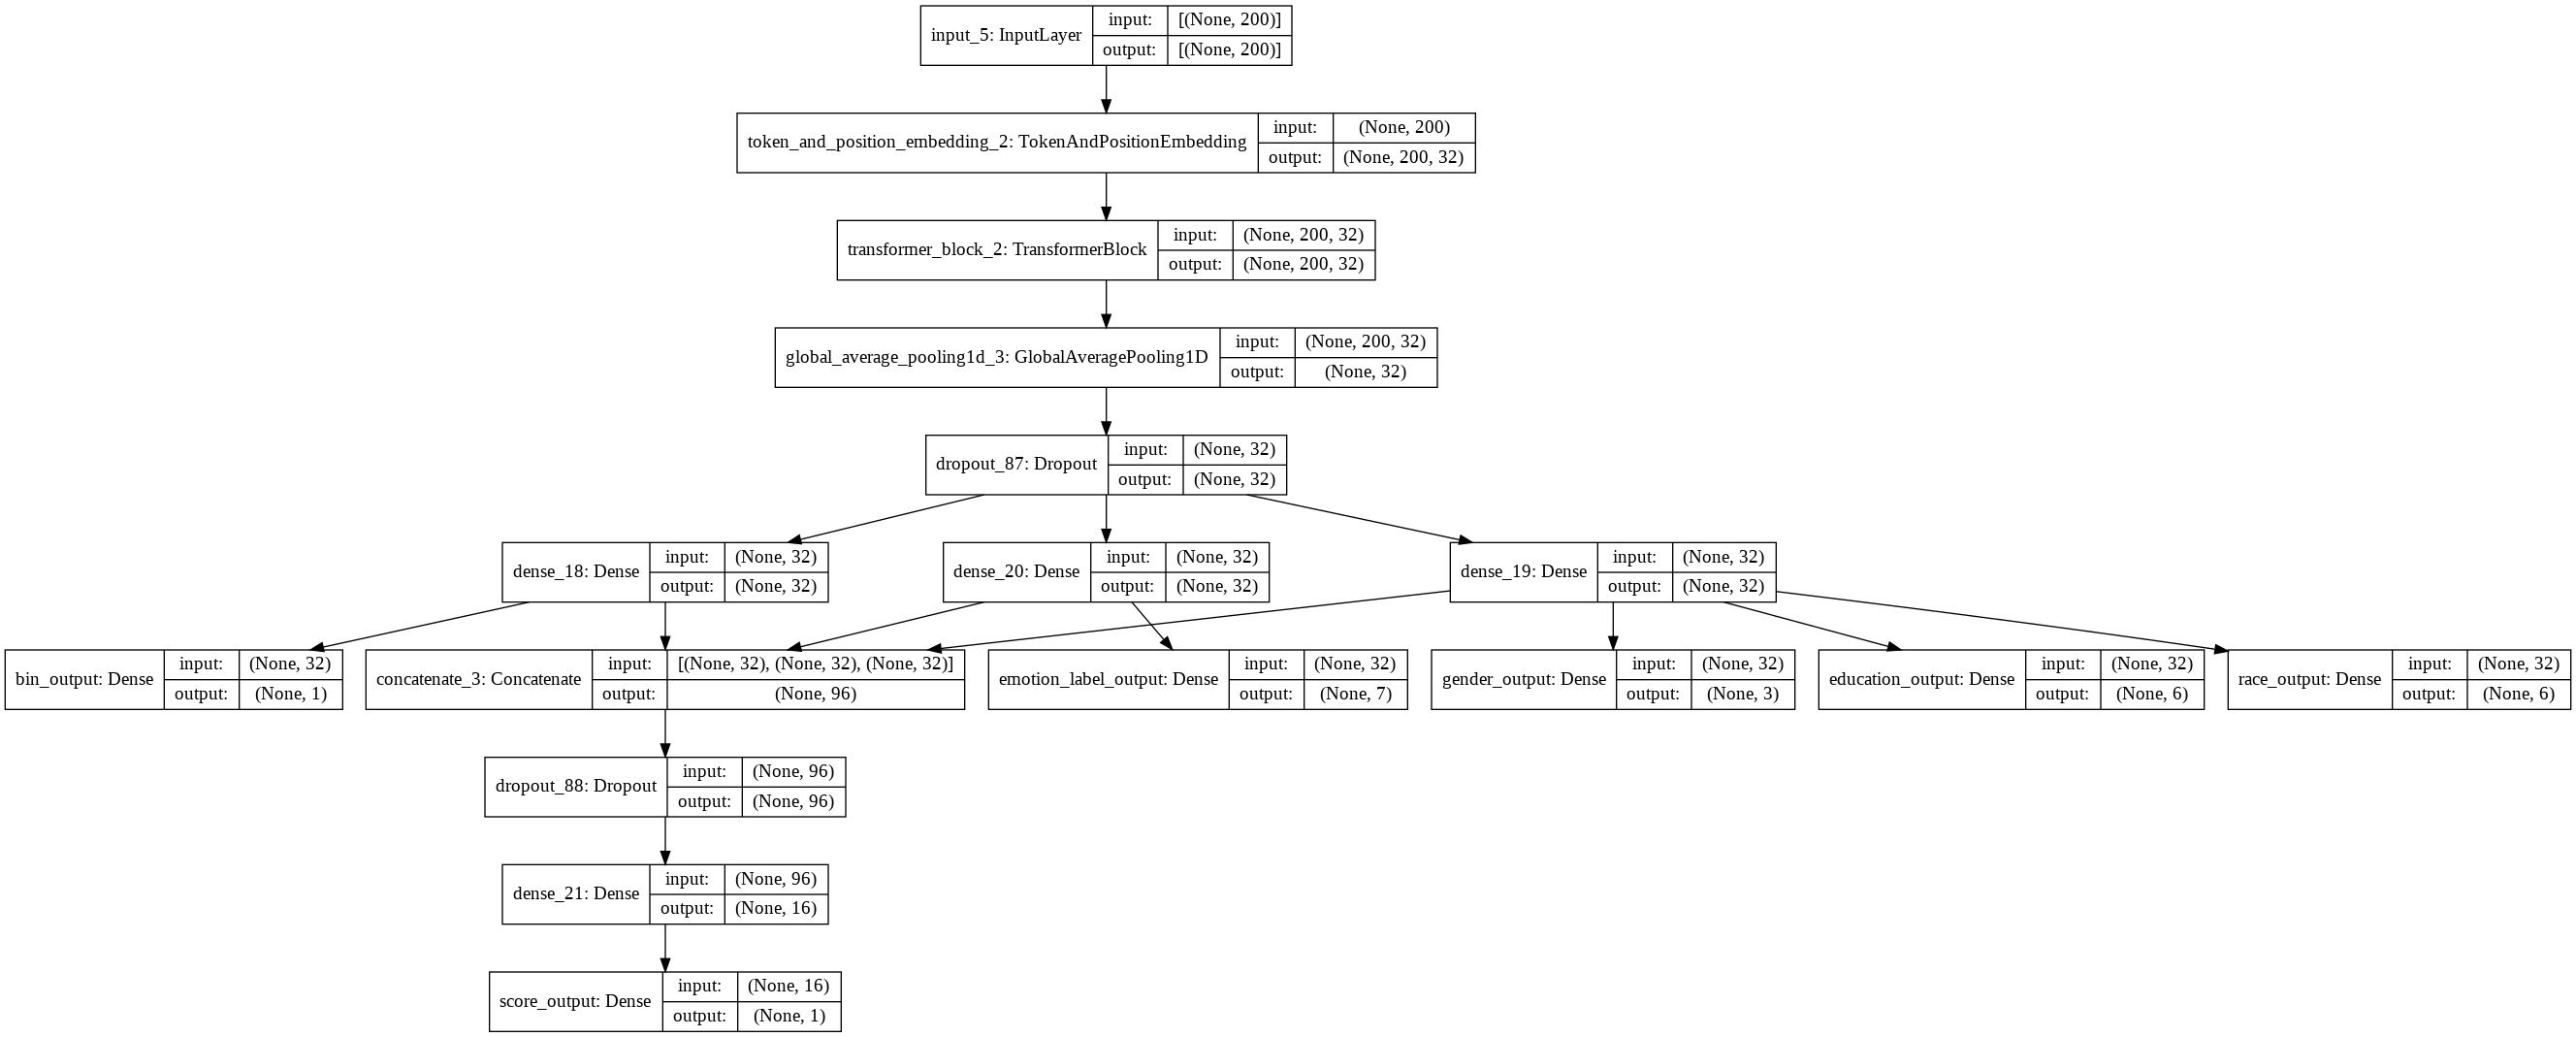

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(prepared_train_essay,
                    train_outputs, 
                    epochs=200, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (prepared_val_essay, val_outputs))

In [ ]:
model_name = "nateraw/bert-base-uncased-emotion"
# model_name = "cardiffnlp/twitter-roberta-base-sentiment"  ----> yes
#model_name = "cardiffnlp/twitter-roberta-base"
#config = AutoConfig.from_pretrained(model_name)
bert_tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
bert_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at nateraw/bert-base-uncased-emotion were not used when initializing BertModel: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
